In [1]:
from typing import TypedDict, Annotated
from langgraph.graph import add_messages, StateGraph, END
from langchain_groq import ChatGroq
from langchain_core.messages import AIMessage, HumanMessage
from dotenv import load_dotenv
from langchain_tavily import TavilySearch
from langgraph.prebuilt import ToolNode

In [2]:
load_dotenv()

class ChildState(TypedDict):
    messages: Annotated[list, add_messages]

search_tool = TavilySearch(max_results=2)
tools = [search_tool]

llm = ChatGroq(model="llama-3.1-8b-instant")

llm_with_tools = llm.bind_tools(tools=tools)

In [3]:
def agent(state: ChildState):
    return {
        "messages": [llm_with_tools.invoke(state["messages"])], 
    }

def tools_router(state: ChildState):
    last_message = state["messages"][-1]

    if(hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0):
        return "tool_node"
    else: 
        return END
    

tool_node = ToolNode(tools=tools)

In [6]:
subgraph = StateGraph(ChildState)

subgraph.add_node("agent", agent)
subgraph.add_node("tool_node", tool_node)
subgraph.set_entry_point("agent")

subgraph.add_conditional_edges("agent", tools_router,{
    "tool_node": "tool_node",
    END: END
})
subgraph.add_edge("tool_node", "agent")

search_app = subgraph.compile()

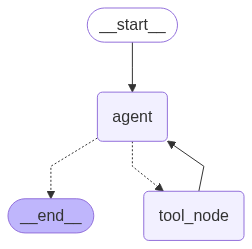

In [7]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        search_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [12]:
search_app.invoke({"messages": [HumanMessage(content="weather in kolkata")]})

{'messages': [HumanMessage(content='weather in kolkata', additional_kwargs={}, response_metadata={}, id='0adc3d3f-ae8d-41e6-a9f4-f5eb7f267a24'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '8bb71gp9a', 'function': {'arguments': '{"query":"Kolkata weather","topic":"news"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 1790, 'total_tokens': 1814, 'completion_time': 0.034215688, 'prompt_time': 0.124563952, 'queue_time': 0.046978247, 'total_time': 0.15877964}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_2115512ff6', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--71ff290f-7166-4045-ad9f-d03da34f2cd0-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'Kolkata weather', 'topic': 'news'}, 'id': '8bb71gp9a', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1790, 'output_tokens': 24, 'total_tokens': 1814}),
  ToolMessage

In [10]:
search_tool.invoke("weather in kolkata")

{'query': 'weather in kolkata',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'Weather in Kolkata',
   'url': 'https://www.weatherapi.com/',
   'content': "{'location': {'name': 'Kolkata', 'region': 'West Bengal', 'country': 'India', 'lat': 22.5697, 'lon': 88.3697, 'tz_id': 'Asia/Kolkata', 'localtime_epoch': 1756882117, 'localtime': '2025-09-03 12:18'}, 'current': {'last_updated_epoch': 1756881900, 'last_updated': '2025-09-03 12:15', 'temp_c': 29.4, 'temp_f': 84.9, 'is_day': 1, 'condition': {'text': 'Mist', 'icon': '//cdn.weatherapi.com/weather/64x64/day/143.png', 'code': 1030}, 'wind_mph': 16.6, 'wind_kph': 26.6, 'wind_degree': 122, 'wind_dir': 'ESE', 'pressure_mb': 1003.0, 'pressure_in': 29.62, 'precip_mm': 0.15, 'precip_in': 0.01, 'humidity': 84, 'cloud': 75, 'feelslike_c': 36.1, 'feelslike_f': 97.1, 'windchill_c': 28.8, 'windchill_f': 83.9, 'heatindex_c': 34.6, 'heatindex_f': 94.4, 'dewpoint_c': 25.5, 'dewpoint_f': 77.8, 'vis_km': 3.5, 'vis_mi

Case 1: Shared Schema (Direct Embedding)

In [14]:
from typing import TypedDict, Annotated
from langgraph.graph import add_messages, StateGraph, START, END
from langchain_core.messages import HumanMessage

# Define parent graph with the same schema
class ParentState(TypedDict):
    messages: Annotated[list, add_messages]

# Create parent graph
parent_graph = StateGraph(ParentState)

# Add the subgraph as a node
parent_graph.add_node("search_agent", search_app)

# Connect the flow
parent_graph.add_edge(START, "search_agent")
parent_graph.add_edge("search_agent", END)

# Compile parent graph
parent_app = parent_graph.compile()

# Run the parent graph
result = parent_app.invoke({"messages": [HumanMessage(content="How is the weather in kolkata?")]})
result

{'messages': [HumanMessage(content='How is the weather in kolkata?', additional_kwargs={}, response_metadata={}, id='6a99a96b-899f-477e-a905-406ca85ff95c'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'c0af38ryj', 'function': {'arguments': '{"query":"kolkata weather","topic":"news"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 1794, 'total_tokens': 1818, 'completion_time': 0.036180664, 'prompt_time': 0.138700047, 'queue_time': 0.051289062, 'total_time': 0.174880711}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_7083106d2c', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--b18cfb12-2fbf-444a-b5a2-84bd19e6338d-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'kolkata weather', 'topic': 'news'}, 'id': 'c0af38ryj', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1794, 'output_tokens': 24, 'total_tokens': 1818}),


Case 2: Different Schema (Invoke with Transformation)

In [18]:
from typing import TypedDict, Annotated, Dict
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage

# Define parent graph with different schema
class QueryState(TypedDict):
    query: str
    response: str

# Function to invoke subgraph
def search_agent(state: QueryState) -> Dict:
    # Transform from parent schema to subgraph schema
    subgraph_input = {
        "messages": [HumanMessage(content=state["query"])]
    }
    
    # Invoke the subgraph
    subgraph_result = search_app.invoke(subgraph_input)
    
    # Transform response back to parent schema
    assistant_message = subgraph_result["messages"][-1]
    return {"response": assistant_message.content}

# Create parent graph
parent_graph = StateGraph(QueryState)

# Add transformation node that invokes subgraph
parent_graph.add_node("search_agent", search_agent)

# Connect the flow
parent_graph.add_edge(START, "search_agent")
parent_graph.add_edge("search_agent", END)

# Compile parent graph
parent_app = parent_graph.compile()

# Run the parent graph
result = parent_app.invoke({"query": "How is the weather in kolkata today?", "response": ""})
print(result)

{'query': 'How is the weather in kolkata today?', 'response': 'The weather in Kolkata today is not explicitly stated in the search results provided. However, a fertilizer shipment is expected to arrive from Kolkata within the next 10 days, suggesting that Kolkata is a port city that is likely to experience good weather at this time of year.\n\nTo get a more accurate answer, I would recommend searching for more specific information about the weather in Kolkata. For example, I could try searching for "Kolkata weather today" or "Kolkata weather forecast."'}
